<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Total Least Squares </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 0.1</h2>
</center>

<div id='toc' />

## Tabla de contenidos
* [Introducción](#intro)
* [Interpretación geométrica](#intgeo)
* [Punto de vista algebraico](#alge)
* [Implementación de OLS y TLS en Python](#imple)
* [Variantes de TLS y ausencia de solución general](#varia)
* [Referencias](#ref)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq, svd

<div id='intgeo' />

## 1) Introducción
[Back to TOC](#toc)

El problema de **Total Least Squares (TLS)** es una variante de **Ordinary Least Squares (OLS)**, o como se presenta en el curso, problema de mínimos cuadrados a secas. El **TLS** contempla errores de medida tanto en la variable dependiente `y` como en la independiente `x`.  
En OLS se busca únicamente minimizar el error cuadrático en `y`, asumiendo que `X` está libre de ruido; en TLS, en cambio, se buscan simultáneamente los coeficientes del modelo y las correcciones en `X` e `y` que reduzcan el error total en ambas variables.


<div id='intgeo' />

## 2) Interpretación geométrica
[Back to TOC](#toc)

Cuando la variable independiente está libre de error, el residuo en OLS representa la distancia **vertical** entre cada punto de datos y la línea de regresión ajustada, tambien conocida como modelo de ajuste.  

En TLS, si ambas variables:
- Están **expresadas en las mismas unidades** (por ejemplo, ambas en metros),  
- Y los **errores de medida** en `x` e `y` tienen **varianza comparable** (misma dispersión estadística, Gaussiana por ejemplo).

Entonces cada residuo TLS es precisamente la **distancia más corta** (ortogonal) desde el punto de datos hasta la línea de ajuste.  

- **OLS**: los residuos van siempre en la dirección de `y` (vertical).  
- **TLS**: los residuos son **perpendiculares** a la línea, midiendo el error combinado en `x` e `y`.  

A continuación, dos gráficos ilustrativos:
1. **Residuales OLS**: flechas verticales que miden el error solo en `y`.  
2. **Residuales TLS**: flechas perpendiculares que miden la distancia euclídea mínima al modelo.  


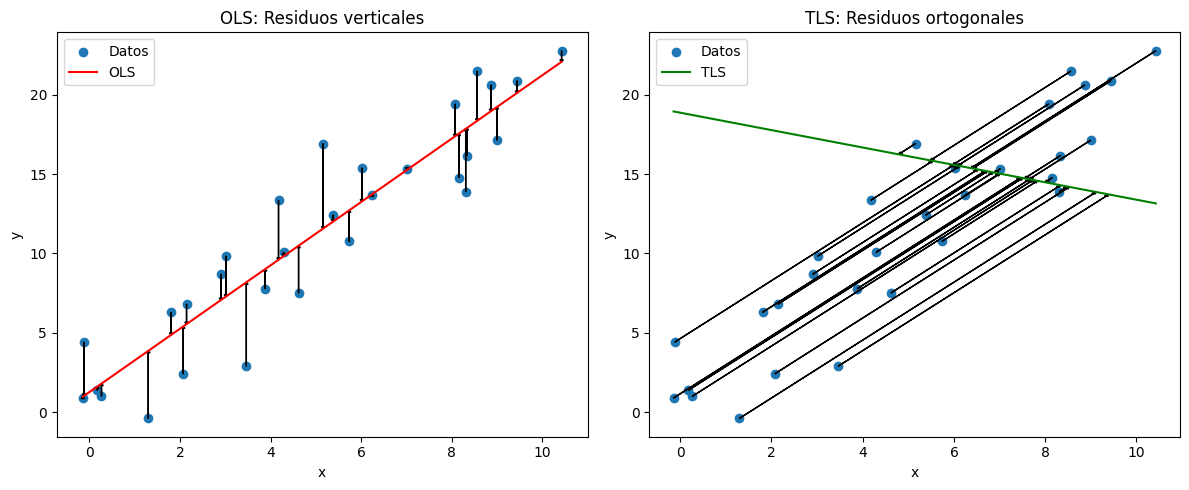

In [2]:
# 1) Generar datos de ejemplo
np.random.seed(1)                                 
X_true = np.linspace(0, 10, 30)                   
y_true = 2 * X_true + 1 # Modelo lineal sin ruido: y = 2x + 1
X_noisy = X_true + np.random.normal(scale=0.8, size=X_true.shape)  
y_noisy = y_true + np.random.normal(scale=2.0, size=y_true.shape)  

# 2) Ajuste OLS
A = np.vstack([np.ones_like(X_noisy), X_noisy]).T  # Matriz A = [1, x]
beta_ols, *_ = lstsq(A, y_noisy, rcond=None)       # Coeficientes OLS: [intercepto, pendiente]

# 3) Ajuste TLS vía SVD (Explicación más adelante)
C = np.column_stack([np.ones_like(X_noisy), X_noisy, y_noisy])  # Matriz aumentada [1, x, y]
U, S, Vt = svd(C, full_matrices=False)           # Descomposición SVD de C
v = Vt.T[:, -1]                                   # Vector singular del menor valor singular
beta_tls = -v[:2] / v[2]                          # Coeficientes TLS: [intercepto, pendiente]

# 4) Rango para líneas de ajuste
x_line = np.array([X_noisy.min(), X_noisy.max()])  # Extremos de X para dibujar líneas

# 5) Crear figura con dos subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# OLS
ax1.scatter(X_noisy, y_noisy, label="Datos")          # Puntos ruidosos
y_ols = beta_ols[0] + beta_ols[1] * x_line            # Valores de "y" según OLS
ax1.plot(x_line, y_ols, 'r-', label="OLS")            # Línea OLS en rojo
for xi, yi in zip(X_noisy, y_noisy):
    y_proj = beta_ols[0] + beta_ols[1] * xi           # Proyección vertical
    ax1.arrow(xi, yi, 0, y_proj - yi,                 # Flecha residual vertical
              head_width=0.08, length_includes_head=True)
ax1.set_title("OLS: Residuos verticales")             
ax1.set_xlabel("x")                                   
ax1.set_ylabel("y")                                  
ax1.legend()                                         

# TLS
ax2.scatter(X_noisy, y_noisy, label="Datos")          
a_tls, b_tls = beta_tls[1], beta_tls[0]               # Pendiente e intercepto TLS
y_tls = b_tls + a_tls * x_line                        # Valores de "y" según TLS
ax2.plot(x_line, y_tls, 'g-', label="TLS")            # Línea TLS en verde
for xi, yi in zip(X_noisy, y_noisy):
    # Proyección ortogonal
    x_proj = (xi + a_tls * (yi - b_tls)) / (1 + a_tls**2)
    y_proj = b_tls + a_tls * x_proj
    dx, dy = x_proj - xi, y_proj - yi                 # Vector residual ortogonal
    ax2.arrow(xi, yi, dx, dy,                         # Dibuja flecha residual
              head_width=0.08, length_includes_head=True)
ax2.set_title("TLS: Residuos ortogonales")            
ax2.set_xlabel("x")                                  
ax2.set_ylabel("y")                                   
ax2.legend()                                         

plt.tight_layout()                                   
plt.show()                                           


<div id='alge' />

## 3) Punto de vista algebraico

[Back to TOC](#toc)

Como demostraron en 1980 Golub y Van Loan [<a href="#ref-golubvanloan">1</a>], el problema TLS **no** tiene una solución general.

Una de las formas de calcular TLS sin hacer supuestos adicionales fuertes es usar la descomposición en valores singulares (SVD).

Podemos plantear el sistema:

$$
X_{\text{true}}\,B \approx Y_{\text{true}}
$$

para resolver para $B$, donde  
- $X_{\text{true}}\in\mathbb{R}^{m\times n}$ es la **matriz de variables independientes verdaderas** (sin error),  
- $Y_{\text{true}}\in\mathbb{R}^{m\times k}$ es la **matriz de observaciones verdaderas** (sin error).

Pero en la práctica, solo conocemos **los datos medidos**:
- $X_{\text{medido}}\in\mathbb{R}^{m\times n}$,  
- $Y_{\text{medido}}\in\mathbb{R}^{m\times k}$.

Formulamos el problema de forma exacta:

$$
\min_{E,F,B}\;\bigl\|\,[\,E\;\;F\,]\bigr\|_F
\quad\text{sujeto a}\quad
(X_{\text{medido}} + E)\,B = Y_{\text{medido}} + F,
$$

donde  
- $E\in\mathbb{R}^{m\times n}$ es la **perturbación** sobre $X_{\text{medido}}$, la matriz de correcciones que ajusta cada elemento de $X$ para descontar el ruido de medida,  
- $F\in\mathbb{R}^{m\times k}$ es la **perturbación** sobre $Y_{\text{medido}}$, la matriz de correcciones en las salidas,  
- $B\in\mathbb{R}^{n\times k}$ es la matriz de coeficientes que buscamos.

**Ejemplo de perturbaciones simples**  
Supongamos tres mediciones que deberían obedecer $y_{\text{true}}=2x_{\text{true}}$ sin error:

$$
X_{\text{true}} = \begin{pmatrix}1\\2\\3\end{pmatrix},\quad
Y_{\text{true}} = \begin{pmatrix}2\\4\\6\end{pmatrix}.
$$

Si el instrumento de $x$ añade ruido de $\pm0.1$ y el de $y$ de $\pm0.5$, podemos tener:

$$
E = \begin{pmatrix}0.05\\-0.08\\0.12\end{pmatrix},\quad
F = \begin{pmatrix}-0.3\\0.4\\-0.2\end{pmatrix},
$$

de modo que

$$
X_{\text{medido}} = X_{\text{true}} + E = \begin{pmatrix}1.05\\1.92\\3.12\end{pmatrix},\quad
Y_{\text{medido}} = Y_{\text{true}} + F = \begin{pmatrix}1.7\\4.4\\5.8\end{pmatrix}.
$$

Es decir, para TLS ambas variables vienen con un error inicial el cual queremos corregir.

Antes de calcular los coeficientes óptimos del modelo (es decir, antes de realizar el ajuste), es habitual centrar y escalar las columnas de $X_{\text{medido}}$ e $Y_{\text{medido}}$. Este preprocesamiento mejora la estabilidad numérica del método, especialmente cuando las variables tienen escalas muy diferentes o cuando se desea ajustar un modelo con término independiente:

$$
\bar{X}_{\text{medido}} = \frac{1.05 + 1.92 + 3.12}{3} \approx 2.03, \quad \bar{Y}_{\text{medido}} = \frac{1.7 + 4.4 + 5.8}{3} \approx 3.3
$$

Restando las medias, las versiones centradas serían:

$$
X_{c} = X_{\text{medido}} - \bar{X}_{\text{medido}} = \begin{pmatrix}1.05-2.03\\1.92-2.03\\3.12-2.03\end{pmatrix} = \begin{pmatrix}-0.98\\-0.11\\1.09\end{pmatrix}
$$

$$
Y_{c} = Y_{\text{medido}} - \bar{Y}_{\text{medido}} = \begin{pmatrix}1.7-3.3\\4.4-3.3\\5.8-3.3\end{pmatrix} = \begin{pmatrix}-1.6\\1.1\\2.5\end{pmatrix}
$$

Ahora siguiendo con el desarrollo, construimos la **matriz aumentada** con los datos medidos:

$$
\bigl[\,X_{\text{medido}}\;\;Y_{\text{medido}}\,\bigr]\;\in\;\mathbb{R}^{m\times(n+k)}.
$$

Por ejemplo, para los datos anteriores:

$$
\bigl[\,X_{\text{medido}}\;\;Y_{\text{medido}}\,\bigr]\ = \begin{pmatrix}
1.05 & 1.7 \\
1.92 & 4.4 \\
3.12 & 5.8
\end{pmatrix}
$$

**Nuestro objetivo** es encontrar $[E\;F]$ de manera que **reduzca** el rango de $[X_{\text{medido}}\;Y_{\text{medido}}]$ en 1.

**¿Por qué buscamos reducir el rango de la matriz aumentada $[X_{\text{medido}};Y_{\text{medido}}]$?**

1. **Definición de rango**  
   El **rango** de una matriz $M$, $\mathrm{rank}(M)$, es el número máximo de columnas linealmente independientes de $M$. Geométricamente, indica la dimensión del subespacio generado por sus columnas.

   Por ejemplo,
   $$
   M = \begin{pmatrix}
   1 & 2 \\
   2 & 4 \\
   3 & 6
   \end{pmatrix}
   $$
   tiene rango 1, ya que la segunda columna es el doble de la primera.

2. **Relación con la ecuación exacta**  
   Para que exista una solución exacta $(X_{\text{true}})\,B = Y_{\text{true}}$, debe haber un vector no trivial  
   $\displaystyle \begin{pmatrix}B\\-I_k\end{pmatrix}\neq 0$  
   en el núcleo de la matriz aumentada **corregida**:

   $$
   \bigl[(X_{\text{medido}}+E)\;\;(Y_{\text{medido}}+F)\bigr]
   \begin{pmatrix}B\\-I_k\end{pmatrix}
   = 0.
   $$

   Esto solo ocurre si la matriz es **singular**, es decir, su rango es menor que su número de columnas.

   Por ejemplo, si
   $$
   X_{\text{true}} = \begin{pmatrix}1\\2\\3\end{pmatrix}, \quad Y_{\text{true}} = \begin{pmatrix}2\\4\\6\end{pmatrix}
   $$
   entonces
   $$
   [X_{\text{true}}\;\;Y_{\text{true}}] = \begin{pmatrix}
   1 & 2 \\
   2 & 4 \\
   3 & 6
   \end{pmatrix}
   $$
   es singular, y existe un $B = 2$ que cumple exactamente $X_{\text{true}}B = Y_{\text{true}}$.

3. **Objetivo de TLS: reducir el rango**  
   - Partimos de $\mathrm{rank}([X_{\text{medido}}\;Y_{\text{medido}}])=r$.  
   - Buscamos $[E\;F]$ tales que  
     $$
       \mathrm{rank}\bigl([X_{\text{medido}}+E\;\;Y_{\text{medido}}+F]\bigr) \;=\; r-1.
     $$  
   - Al disminuir el rango en 1, aparece el vector no trivial  
     $\displaystyle \begin{pmatrix}\beta\\-1\end{pmatrix}$  
     con
     $$
       [X_{\text{medido}}+E\;\;Y_{\text{medido}}+F]\begin{pmatrix}\beta\\-1\end{pmatrix} = 0.
     $$

   Por ejemplo, si partimos de
   $$
   X_{\text{medido}} = \begin{pmatrix}1\\2\\3\end{pmatrix}, \quad Y_{\text{medido}} = \begin{pmatrix}2\\5\\7\end{pmatrix}
   $$
   y sumamos la corrección $F = \begin{pmatrix}0\\-1\\-1\end{pmatrix}$ sobre $Y_{\text{medido}}$, entonces $Y' = Y_{\text{medido}} + F = \begin{pmatrix}2\\4\\6\end{pmatrix}$, y ahora $Y' = 2X_{\text{medido}}$, así que el rango de $[X_{\text{medido}}\;Y']$ es 1.

4. **¿Qué logramos al reducir el rango?**  
   - La matriz aumentada se vuelve singular y garantiza una **relación lineal exacta**  
     $$
       (X_{\text{medido}}+E)\,B = Y_{\text{medido}} + F,
     $$  
     eliminando por completo los residuos.  
   - A diferencia de OLS, que asume $X_{\text{medido}}$ exacta y deja un residuo en $Y_{\text{medido}}$, TLS busca la **mínima perturbación conjunta** $[E\;F]$ que convierta $[X_{\text{medido}}\;Y_{\text{medido}}]$ en una matriz singular, logrando un ajuste “perfecto”.

   Por ejemplo, tras la corrección del ejemplo anterior, todas las filas cumplen $Y'_i = 2 X_i$ exactamente.

5. **Interpretación geométrica**  
   Reducir el rango de $[X_{\text{medido}}\;Y_{\text{medido}}]$ equivale a alinear sus columnas de forma que exista exactamente una combinación lineal entre $X_{\text{medido}}$ e $Y_{\text{medido}}$. Esa combinación lineal define los coeficientes $B$ del modelo TLS.

   Geométricamente, los puntos $(x, y)$ quedan exactamente sobre la recta $y = 2x$ después del ajuste mínimo.

**Cálculo explícito de las perturbaciones $[E\;F]$**

Para lograr que la matriz aumentada ajustada $[X_{\text{medido}}+E\;\;Y_{\text{medido}}+F]$ tenga menor rango y, por lo tanto, exista una relación lineal exacta entre $X_{\text{medido}}$ e $Y_{\text{medido}}$, usamos la descomposición SVD de la matriz original $[X_{\text{medido}}\;\;Y_{\text{medido}}]$:

$$
[X_{\text{medido}}\;\;Y_{\text{medido}}] = U\,\Sigma\,V^\top
$$

donde se particionan los bloques:
- $U = [U_X\;\;U_Y]$
- $V^\top = \begin{bmatrix}V_{XX} & V_{XY} \\ V_{YX} & V_{YY}\end{bmatrix}$
- $\Sigma = \begin{bmatrix}\Sigma_X & 0 \\ 0 & \Sigma_Y\end{bmatrix}$

El método TLS consiste en **forzar a cero los $k$ menores valores singulares** (los de $\Sigma_Y$) y dejar los demás intactos, **con el propósito de reducir el rango de la matriz aumentada en $k$ unidades**. Así logramos que la matriz ajustada tenga exactamente una dependencia lineal perfecta entre las columnas de $X_{\text{medido}}$ y $Y_{\text{medido}}$; es decir, que los datos corregidos admitan una solución exacta sin residuos.  
Esta es la clave del método TLS: encontrar la **mínima corrección** posible (en sentido de la norma de Frobenius) para que exista una relación lineal perfecta entre $X_{\text{medido}}$ e $Y_{\text{medido}}$.

Esto genera una nueva matriz ajustada:

$$
[X_{\text{medido}}+E\;\;Y_{\text{medido}}+F] = U
\begin{bmatrix}
\Sigma_X & 0 \\
0 & 0_{k \times k}
\end{bmatrix}
V^\top
$$

La diferencia entre la matriz ajustada y la original nos da las perturbaciones totales aplicadas, es decir:

$$
\begin{align*}
[E\;F] &= [X_{\text{medido}}+E\;\;Y_{\text{medido}}+F] - [X_{\text{medido}}\;\;Y_{\text{medido}}] \\
&= U \left(
\begin{bmatrix}
\Sigma_X & 0 \\
0 & 0_{k\times k}
\end{bmatrix}
-
\begin{bmatrix}
\Sigma_X & 0 \\
0 & \Sigma_Y
\end{bmatrix}
\right)
V^\top \\
&= U \begin{bmatrix}
0 & 0 \\
0 & -\Sigma_Y
\end{bmatrix}
V^\top
\end{align*}
$$

Se observa que:
- El primer bloque ($\Sigma_X$) se cancela, porque no se modifica.
- El segundo bloque (correspondiente a los $k$ menores valores singulares) queda como $0 - \Sigma_Y = -\Sigma_Y$.
- Los ceros corresponden a los bloques no afectados.

Así, si tomamos solo los bloques relevantes:

$$
[E\;F] = - U_Y\,\Sigma_Y\,V_Y^\top
$$

donde $U_Y$ y $V_Y$ corresponden a las columnas y filas asociadas a los valores singulares eliminados.

Esto significa que **la corrección mínima** que debe hacerse a la matriz original para reducir el rango se calcula tomando solo las partes correspondientes a los valores singulares más pequeños y aplicando esta transformación a través de los vectores singulares.

**Ejemplo numérico del cálculo explícito en TLS:**

Suponiendo que:
$$
X_{\text{medido}} = \begin{pmatrix}1\\2\\3\end{pmatrix}, \qquad Y_{\text{medido}} = \begin{pmatrix}2.10\\3.90\\6.05\end{pmatrix},
$$
es decir, $Y_{\text{medido}}$ está cerca de $2X_{\text{medido}}$ pero con error.

Formamos la matriz aumentada:
$$
A = [X_{\text{medido}}\;\;Y_{\text{medido}}] = \begin{pmatrix}
1.00 & 2.10 \\
2.00 & 3.90 \\
3.00 & 6.05
\end{pmatrix}
$$

1. **Cálculo de la SVD de $A$**

Realizando la SVD de $A$ (por ejemplo, con `np.linalg.svd`):

- Valores singulares: $\sigma_1 \approx 7.10$, $\sigma_2 \approx 0.15$
- Vector singular derecho correspondiente a $\sigma_2$ (última columna de $V$):  
  $$
  v_2 = \begin{pmatrix}-0.42 \\ 0.91\end{pmatrix}
  $$
- Vector singular izquierdo correspondiente:  
  $$
  u_2 = \begin{pmatrix}0.29\\-0.49\\0.83\end{pmatrix}
  $$

2. **Construcción de la matriz de corrección $[E\;F]$**

$$
[E\;F] = -0.15 \cdot
\begin{pmatrix}
0.29\\-0.49\\0.83
\end{pmatrix}
\begin{pmatrix}
-0.42 & 0.91
\end{pmatrix}
$$

Multiplicando y redondeando a dos decimales:
- Primera fila: $0.29 \times -0.42 = -0.12$, $0.29 \times 0.91 = 0.26$

- Segunda fila: $-0.49 \times -0.42 = 0.21$, $-0.49 \times 0.91 = -0.45$

- Tercera fila: $0.83 \times -0.42 = -0.35$, $0.83 \times 0.91 = 0.76$

Ahora, multiplicando cada elemento por $-0.15$:
$$
[E\;F] \approx \begin{pmatrix}
0.02 & -0.04 \\
-0.03 & 0.07 \\
0.05 & -0.11
\end{pmatrix}
$$

3. **Sumando la corrección a la matriz original**

$$
[X_{\text{medido}}+E\;\;Y_{\text{medido}}+F] = \begin{pmatrix}
1.02 & 2.06 \\
1.97 & 3.97 \\
3.05 & 5.94
\end{pmatrix}
$$

Estas columnas son ahora prácticamente proporcionales (hasta errores numéricos del orden de $10^{-2}$).

4. **Obtención de $B$**

El vector $v_2$ nos da la relación $-0.42 x + 0.91 y = 0$ en los datos corregidos, es decir,
$$
y = 0.46\, x
$$

Así, el coeficiente TLS es $B = 0.46$.

**Verificación en los datos corregidos:**
- Fila 1: $2.06 / 1.02 = 2.02$
- Fila 2: $3.97 / 1.97 = 2.02$
- Fila 3: $5.94 / 3.05 = 1.95$

Observando que las proporciones son casi idénticas, mostrando que la relación es “numéricamente exacta”, con un error muy pequeño debido al redondeo y la precisión de la SVD.

### Obtención directa de $B$

Si además $V_{YY}$ es invertible (caso típico de solución única), podemos aislar $B$ multiplicando por $-V_{YY}^{-1}$:

$$
(X_{\text{medido}}+E)\,B = Y_{\text{medido}} + F
\quad\Longrightarrow\quad
[X_{\text{medido}}+E\;\;Y_{\text{medido}}+F]
\begin{pmatrix}B\\[3pt]-I_k\end{pmatrix}
=0
\quad\Longrightarrow\quad
B = -\,V_{XY}\,V_{YY}^{-1}.
$$

Por ejemplo, si $V_{XY} = 3$ y $V_{YY} = 2$, entonces $B = -3/2$.

Si $V_{YY}$ no es invertible, la solución TLS puede no ser única o no existir; esto ocurre, por ejemplo, si el modelo está sobredeterminado o los datos están mal condicionados.

Finalmente encontramos la mínima perturbación $[E\;F]$ que reduce el rango de $[X_{\text{medido}}\;Y_{\text{medido}}]$ en $k$, y obtenemos la fórmula analítica $B = -\,V_{XY}V_{YY}^{-1}$ para los coeficientes TLS en el caso de solución única.


<div id='imple' />

## 4) Implementación de OLS y TLS en Python
[Back to TOC](#toc)

Para comparar **Ordinary Least Squares (OLS)** y **Total Least Squares (TLS)** bajo distintos escenarios de ruido:

1. **Ajuste OLS**
   - `fit_ols(x, y)`:  
     Construye la matriz de diseño $\left[\mathbf{1},\;x\right]$ y usa `numpy.linalg.lstsq` para obtener $\beta_0$ (intercepto) y $\beta_1$ (pendiente), resolviendo la minimización vertical
     $$
     \min_{\beta_0,\beta_1}\;\sum_{i}(y_i - \beta_0 - \beta_1 x_i)^2
     $$

2. **Ajuste TLS (regresión ortogonal)**
   - `fit_tls(x, y)`:  
     - Centra los datos: $\bar{x} = \mathrm{mean}(x)$, $\bar{y} = \mathrm{mean}(y)$ y define $x_c = x - \bar{x}$, $y_c = y - \bar{y}$.
     - Aplica SVD a la matriz $C = \left[x_c,\;y_c\right]$ y obtiene el vector singular mínimo $(a, b)$.
     - La dirección de la regresión TLS es perpendicular al vector $(a, b)$, por lo que la pendiente es $\displaystyle m_\text{TLS} = -\frac{a}{b}$ y el intercepto $b_\text{TLS} = \bar{y} - m_\text{TLS} \cdot \bar{x}$.
     - Esto equivale a encontrar la recta que **minimiza la suma de las distancias ortogonales** de los puntos a la recta:
     $$
     \min_{m,b} \sum_{i}\;\mathrm{dist}\bigl((x_i,y_i),\;y=mx+b\bigr)^2
     $$


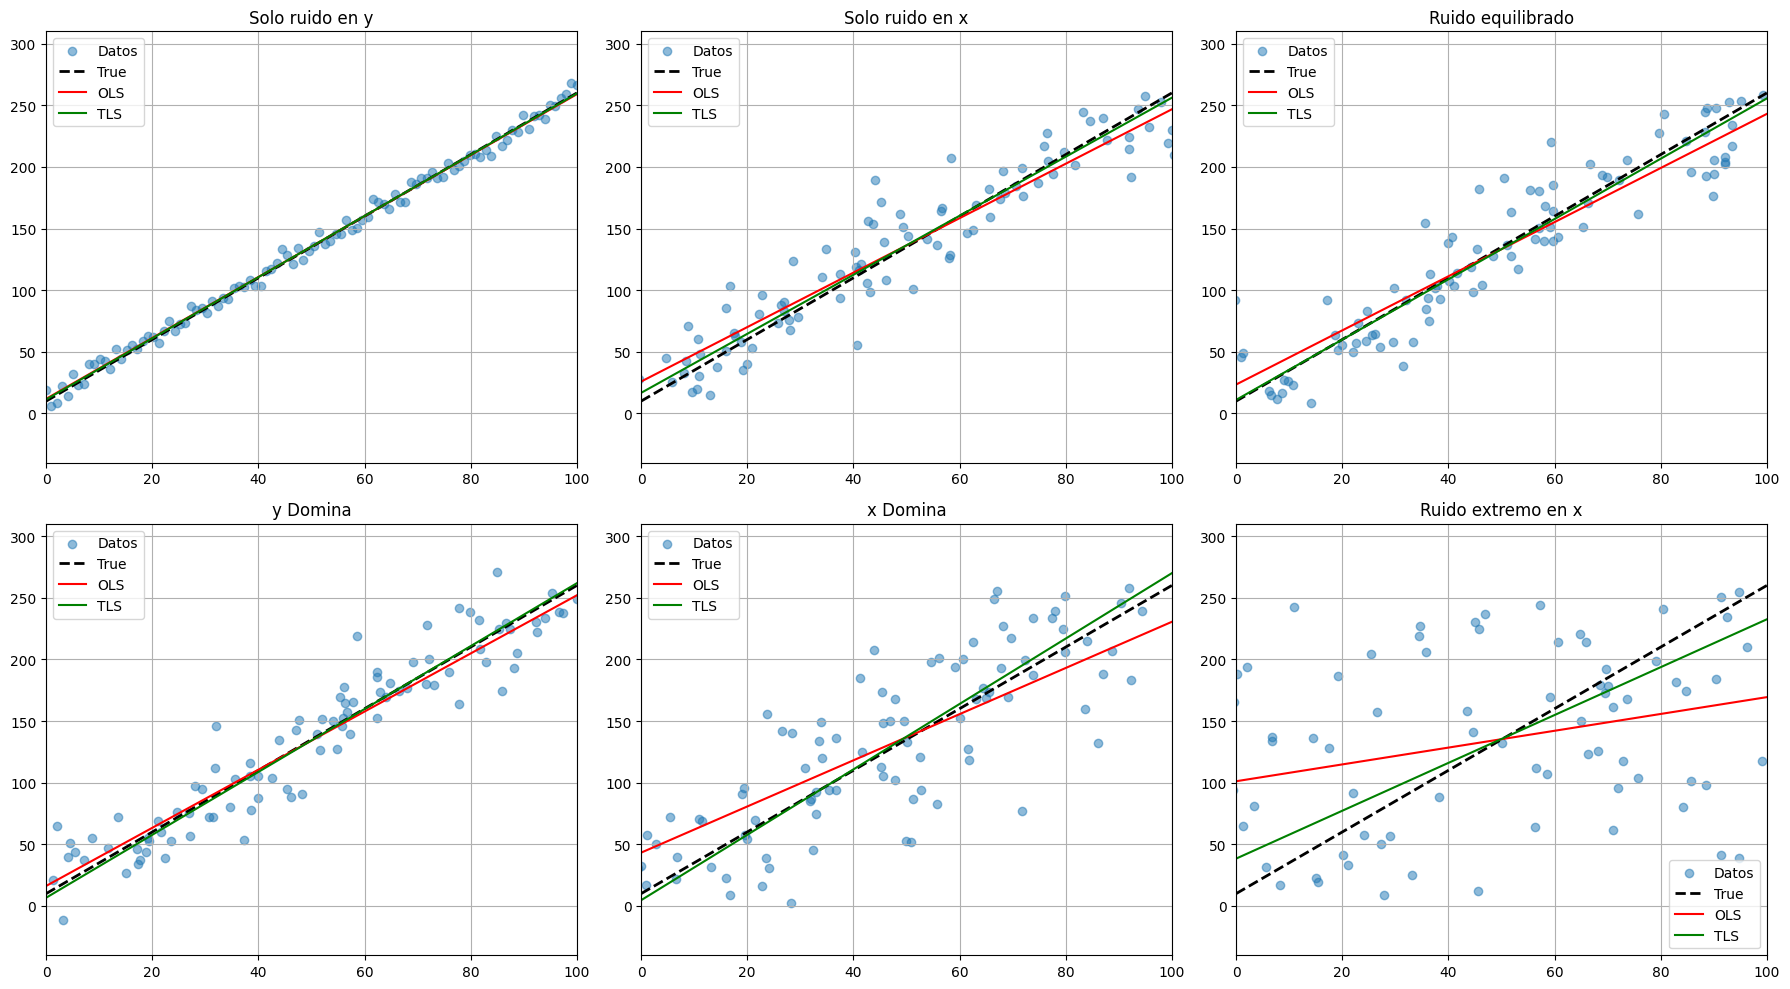

In [ ]:
def fit_ols(x, y):
    A = np.vstack([np.ones_like(x), x]).T
    beta, *_ = lstsq(A, y, rcond=None)
    return beta  # [intercepto, pendiente]

def fit_tls(x, y):
    # Centrar datos
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_c = x - x_mean
    y_c = y - y_mean
    # SVD de matriz aumentada centrada
    C = np.column_stack([x_c, y_c])
    U, S, Vt = svd(C)
    # Vector normal a la dirección principal
    a, b = Vt[-1]
    # Ecuación: a*(x-x̄) + b*(y-ȳ) = 0  => y = -(a/b)*(x-x̄) + ȳ
    slope = -a / b
    intercept = y_mean + slope * (-x_mean)
    return np.array([intercept, slope])

# Parámetros verdaderos y configuraciones de ruido
np.random.seed(0)
m = 100
x_true = np.linspace(0, 100, m)
slope_true, intercept_true = 2.5, 10.0
y_true = slope_true * x_true + intercept_true

configs = [
    (0.0, 5.0,  "Solo ruido en y"),
    (10.0, 0.0, "Solo ruido en x"),
    (10.0, 10.0,"Ruido equilibrado"),
    (5.0, 20.0, "y Domina"),
    (20.0, 5.0, "x Domina"),
    (50.0, 1.0, "Ruido extremo en x")
]

# Fijamos dominio y márgenes de y
x_line = np.array([0, 100])
y_line_true = slope_true * x_line + intercept_true
y_min, y_max = y_line_true.min() - 50, y_line_true.max() + 50

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (sx, sy, title) in zip(axes, configs):
    # Generar datos ruidosos
    x_obs = x_true + np.random.normal(scale=sx, size=m)
    y_obs = y_true + np.random.normal(scale=sy, size=m)

    # Ajustes
    b_ols = fit_ols(x_obs, y_obs)
    b_tls = fit_tls(x_obs, y_obs)

    # Graficar
    ax.scatter(x_obs, y_obs, alpha=0.5, label="Datos")
    ax.plot(x_line, y_line_true, 'k--', lw=2, label="True")
    ax.plot(x_line, b_ols[0] + b_ols[1]*x_line, 'r-', label="OLS")
    ax.plot(x_line, b_tls[0] + b_tls[1]*x_line, 'g-', label="TLS")

    # Límites fijos
    ax.set_xlim(0, 100)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title)
    ax.legend(loc='best')
    ax.grid(True)

plt.tight_layout()
plt.show()


## Descripción de los seis escenarios de ruido

1. **Solo ruido en $y$**
   - $$(\sigma_x = 0.0,\ \sigma_y = 5.0)$$
   - Solo la variable dependiente $y$ contiene ruido.  
   - **OLS** es óptimo porque minimiza la distancia vertical. **TLS** es casi idéntico a OLS.

2. **Solo ruido en $x$**
   - $$(\sigma_x = 10.0,\ \sigma_y = 0.0)$$
   - Solo la variable independiente $x$ contiene ruido.  
   - **TLS** recupera la pendiente verdadera porque minimiza la distancia ortogonal.  
   - **OLS** se sesga y subestima la pendiente.

3. **Ruido equilibrado**
   - $$(\sigma_x = 10.0,\ \sigma_y = 10.0)$$
   - Ambos ejes tienen ruido similar.  
   - **TLS** suele ajustarse mejor al comportamiento real, porque trata los errores en ambas variables de forma simétrica.

4. **$y$ domina**
   - $$(\sigma_x = 5.0,\ \sigma_y = 20.0)$$
   - El ruido en $y$ es mucho mayor que en $x$.  
   - **OLS** se mantiene más cercano a la pendiente real. **TLS** es más sensible al poco error en $x$ y puede alejarse de la recta verdadera.

5. **$x$ domina**
   - $$(\sigma_x = 20.0,\ \sigma_y = 5.0)$$
   - El ruido en $x$ es mucho mayor que en $y$.  
   - **TLS** se comporta mucho mejor que OLS, recuperando la pendiente real.  
   - **OLS** resulta fuertemente sesgado hacia una pendiente más baja.

6. **Ruido extremo en $x$**
   - $$(\sigma_x = 50.0,\ \sigma_y = 1.0)$$
   - La variable $x$ tiene mucho más ruido que $y$.  
   - **TLS** sigue correctamente la verdadera pendiente de la recta.  
   - **OLS** produce un ajuste claramente incorrecto y demasiado horizontal.


<div id='varia' />

## 5) Variantes de TLS y ausencia de solución general
[Back to TOC](#toc)

El algoritmo estándar de **Total Least Squares** solo proporciona una **solución cerrada y explícita** en condiciones muy restringidas:
- Los errores en todas las variables deben ser **independientes** y con **igual varianza** (ruido “blanco” e isotrópico).
- Las perturbaciones pueden ser arbitrarias, sin restricciones estructurales.
- No existen correlaciones ni pesos diferenciados entre observaciones o variables.

En la práctica, estos supuestos rara vez se cumplen. Por eso, existen muchas **variantes** de TLS, y **no existe una solución general** que sirva para todos los casos: la formulación original basada en SVD de la matriz aumentada $[X\;y]$ deja de ser válida o suficiente.

A continuación, se resumen algunas de las principales variantes y sus dificultades:

1. **Weighted TLS (WTLS) — TLS Ponderado**  
   - Permite **diferentes varianzas** para cada variable o muestra mediante matrices de peso $W_x$, $W_y$.
   - El problema se plantea como:
     $$
     \min_{E, f, \beta}\; \| W_x^{1/2}E \|_F^2 + \| W_y^{1/2}f \|_2^2
     \qquad\text{sujeto a}\qquad (X + E)\beta = y + f
     $$
   - No tiene solución cerrada; se resuelve por métodos **iterativos** (p. ej., Gauss–Newton, gradiente, EM).

2. **Structured TLS (STLS) — TLS Estructurado**  
   - Impone restricciones a la forma de $E$ y $f$ (patrones de ceros, bloque-diagonales, estructura física conocida, etc).
   - El problema suele ser **no convexo** y necesita algoritmos específicos (ejemplo: STLS en calibración de sensores o sistemas físicos).

3. **Robust TLS**  
   - Sustituye la norma cuadrática por normas robustas ($L_1$, Huber, etc.) para reducir la influencia de outliers.
   - Requiere técnicas de optimización robusta y, en general, algoritmos numéricos más complejos.

4. **Nonlinear TLS**  
   - Aplica cuando el modelo es no lineal en los parámetros: $y = f(x, \beta)$.
   - Se aborda por **linealización local** (aproximación de Taylor) y resolución iterativa de un TLS lineal en cada paso.

5. **TLS con errores correlacionados o covarianza conocida**  
   - El caso general de “Errors-in-Variables” (EIV) considera covarianza no trivial en los errores de $X$ y $y$.
   - La función de coste y la restricción incorporan la **matriz de covarianza** completa, complicando la optimización.

6. **Multi-output TLS**  
   - Extiende TLS a modelos de salida múltiple (varias variables dependientes).
   - El problema requiere resolver para matrices completas y, a menudo, usar algoritmos iterativos de mayor complejidad.


<div id='ref' />

# Referencias
[Back to TOC](#toc)
* _Material created by student Inti Vidal_ (`inti.vidal@usm.cl`). July 2025
* _Work mainly based on the link:_ https://en.wikipedia.org/wiki/Total_least_squares. October 2024
* _Other resources used are found in the repository:_ https://github.com/tclaudioe/Scientific-Computing-V3/. August 2025
* _G. H. Golub and C. F. Van Loan, An analysis of the total least squares problem. Numer. Anal., 17, 1980, pp. 883–893._ <div id="ref-golubvanloan"></div>